# Evaluation of Blanton K-Corrections
This script makes a statistical comparison between two galaxy K correction estimations:

* On the one and, we will look at Blanton's [kcorrect](https://kcorrect.readthedocs.io/) estimations, which are calculated from photometry and a known redshift value.
* On the other hand, we will look at [FastSpecFit](https://fastspecfit.readthedocs.io/en/latest/) estimations, which are calculated from spectrometry AND photometry, and should therefore be more accurate. These estimations will be considered ground truth.

The dataset of galaxies used corresponds to 200K sources from DESI Early Data Release.

# Load Blanton estimations and inspect columns

The columns of the dataset are:
* targetid:  Source unique identifier in DESI edr
* kcorr_sdss_01_g: K correction at band SDSS-g with band shift 0.1
* kcorr_sdss_01_r: K correction at band SDSS-r with band shift 0.1
* kcorr_sdss_01_z: K correction at band SDSS-z with band shift 0.1
* z: redshift

The dataset has 197063 rows (galaxies).

In [18]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

blanton_kcorrs_path = "../data/blanton_kcorrs.pickle"
blanton_kcorrs_error_log_path = "../data/blanton_kcorrs_error_log.pickle"

with open(blanton_kcorrs_path,"rb") as f:
    kcorr_df = pickle.load(f)

with open(blanton_kcorrs_error_log_path,"rb") as f:
    kcorr_df_log = pickle.load(f)

In [19]:
kcorr_df

,targetid,K_G_G,K_R_G,K_Z_G,K_R_R,K_Z_R,K_Z_Z,absmag_g_g,absmag_g_r,absmag_g_z,absmag_r_r,absmag_z_r,absmag_z_z,z
0,39633062060887564,-0.000247,-0.787448,-1.383028,-0.131278,-0.726858,-0.129439,-21.439207,-21.439205,-21.439207,-22.012806,-22.012808,-22.539633,0.172
1,39632996176760219,0.153279,-0.977347,-1.654718,-0.093075,-0.770445,-0.124495,-21.066877,-21.073978,-21.068201,-21.781038,-21.775261,-22.337879,0.183
2,39633136551725040,-0.044290,-1.110939,-1.809835,-0.144308,-0.843203,-0.132051,-20.261070,-20.261076,-20.261074,-21.024429,-21.024427,-21.660213,0.131
3,39633195544609403,-0.102012,-0.898930,-1.552430,-0.159607,-0.813107,-0.135520,-20.054527,-20.054529,-20.054525,-20.726534,-20.726530,-21.311398,0.116
4,39632935258686219,0.348034,-1.005757,-1.760355,-0.037215,-0.791813,-0.091389,-21.466747,-21.478832,-21.474651,-22.237875,-22.233694,-22.858675,0.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133644,39633448884764959,-0.169279,-0.651794,-1.064635,-0.235993,-0.648835,-0.146249,-16.905325,-16.905323,-16.905323,-17.357868,-17.357870,-17.771414,0.073
133645,39633251840558896,0.820548,-0.461755,-1.388077,0.226605,-0.699717,0.126236,-21.666870,-21.666870,-21.666868,-22.354485,-22.354485,-23.114935,0.494
133646,39633136459448434,2.322228,0.467492,-1.287939,1.321505,-0.433926,0.195951,-23.790026,-23.906002,-23.882492,-24.596214,-24.572704,-25.116306,0.774
133647,39633158366298541,1.281350,-0.075636,-1.351475,0.746957,-0.528882,0.408776,-22.900974,-22.900970,-22.900972,-23.719955,-23.719955,-24.561043,0.643


In [20]:
for k,v in kcorr_df_log.items():
    print(f"There are {len(v)} instances of error {k}")

There are 12716 instances of error Maximum number of iterations reached.
There are 87 instances of error Matrix is singular.
There are 76 instances of error Redshift out of range for interpolating A matrix!


In [21]:
kcorr_df.shape

(133649, 14)

# Calculate FastSpecFit band jumps
FastSpecFit includes logic to decide, given a target band and a set of input bands along with a specific redshift, which is the input band that is the closest match to the target band.
Let's reproduce this logic

In [22]:
from speclite import filters
filt_in = filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z')
filt_out = filters.load_filters('sdss2010-g', 'sdss2010-r', 'sdss2010-z')

In [23]:
filt_in.effective_wavelengths

<Quantity [4815.95363513, 6437.79282937, 9229.65786449] Angstrom>

In [24]:
filt_out.effective_wavelengths

<Quantity [4749.22996891, 6205.83223724, 8947.38474083] Angstrom>

In [25]:
input_bands = { "BASS_g" : filt_in.effective_wavelengths.value[0], 
                "BASS_r" : filt_in.effective_wavelengths.value[1], 
                "MzLS_z" : filt_in.effective_wavelengths.value[2] }

target_bands = { "SDSS_g" : filt_out.effective_wavelengths.value[0], 
                 "SDSS_r" : filt_out.effective_wavelengths.value[1], 
                 "SDSS_z" : filt_out.effective_wavelengths.value[2] }

# Let's apply the band shift stipulated by FastSpecFit
band_shift = 0.1
target_bands_shifted = {x: (band_shift + 1) * y for x, y in target_bands.items()}

In [27]:
# ANALYTICAL THRESHOLDS
threshold_1 =  (input_bands["BASS_r"] / target_bands_shifted["SDSS_g"] )  - 1  # Threshold to jump from g to r
threshold_2 =  (input_bands["MzLS_z"] / target_bands_shifted["SDSS_g"] )  - 1  # Threshold to jump from r to z
threshold =  (input_bands["MzLS_z"] / target_bands_shifted["SDSS_r"] )  - 1  # Threshold to jump from r to z

print(f"Band G cut values are {threshold_1} and {threshold_2}")
print(f"Band R cut value is {threshold}")

Band G cut values are 0.23231323269212556 and 0.7667281040400487
Band R cut value is 0.35205041610311594


In [75]:
# Empirical thresholds
threshold_r = 0.3885
threshold_g1 = 0.3031
threshold_g2 = 0.814

In [76]:
def get_column(target_band, z):
    if target_band == "SDSS_g":
        if z > threshold_g2:
            return "K_Z_G"
        elif z > threshold_g1:
            return "K_R_G"
        else:
            return "K_G_G"
    elif target_band == "SDSS_r":
        return ("K_Z_R" if z > threshold_r else "K_R_R")
    elif target_band == "SDSS_z":
        return "K_Z_Z"

# Build a piece-wise estimation, comparable to FastSpecFit

In [77]:
kcorr_df['KCORR01_SDSS_G_BLANTON'] = kcorr_df.apply(lambda row: kcorr_df[get_column('SDSS_g', row['z'])][row.name], axis=1)
kcorr_df['KCORR01_SDSS_R_BLANTON'] = kcorr_df.apply(lambda row: kcorr_df[get_column('SDSS_r', row['z'])][row.name], axis=1)
kcorr_df['KCORR01_SDSS_Z_BLANTON'] = kcorr_df.apply(lambda row: kcorr_df[get_column('SDSS_z', row['z'])][row.name], axis=1)

# Load FastSpecFit estimations and join tables

In [78]:
from astropy.io import fits

# Load the FITS file
filename = '/home/jrodriguez/deep-KCorrect/data/raw/fastspec-fuji.fits'
hdul = fits.open(filename)

fastspec_data = hdul['FASTSPEC'].data

from astropy.table import Table

# Convert FITS_rec to Astropy Table first (if it's not already a Table)
fastspec_table = Table(fastspec_data)

# Filter out columns with more than 1 dimension
valid_columns = [name for name in fastspec_table.colnames if len(fastspec_table[name].shape) <= 1]

# Create a new table with only valid columns
filtered_fastspec_table = fastspec_table[valid_columns]

# Convert the filtered table to a Pandas DataFrame
fastspec_df = filtered_fastspec_table.to_pandas()

# Rename TARGETID in fastspec_df to targetid
fastspec_df = fastspec_df.rename(columns={"TARGETID": "targetid"})

In [79]:
merged_df = kcorr_df.merge(fastspec_df, on="targetid", how="inner")

In [80]:
merged_df.columns

Index(['targetid', 'K_G_G', 'K_R_G', 'K_Z_G', 'K_R_R', 'K_Z_R', 'K_Z_Z',
       'absmag_g_g', 'absmag_g_r', 'absmag_g_z',
       ...
       'SIII_9532_VSHIFT', 'SIII_9532_SIGMA', 'SIII_9532_CONT',
       'SIII_9532_CONT_IVAR', 'SIII_9532_EW', 'SIII_9532_EW_IVAR',
       'SIII_9532_FLUX_LIMIT', 'SIII_9532_EW_LIMIT', 'SIII_9532_CHI2',
       'SIII_9532_NPIX'],
      dtype='object', length=922)

# Visualize the distributions

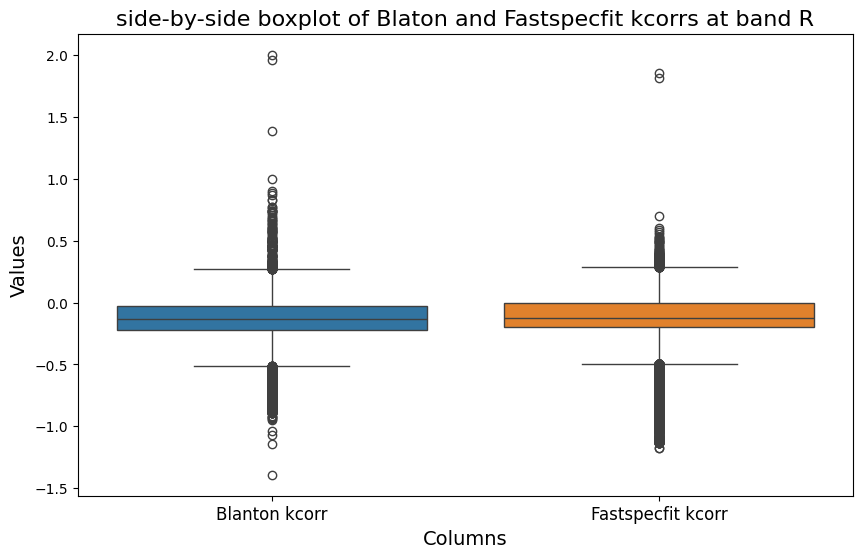

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame
# Create a new DataFrame with the two columns you want to plot side by side
data = merged_df[['KCORR01_SDSS_R_BLANTON', 'KCORR01_SDSS_R']]

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)

# Set plot labels and title
plt.title('side-by-side boxplot of Blaton and Fastspecfit kcorrs at band R', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Custom subtitles for each column
plt.xticks([0, 1], ['Blanton kcorr', 'Fastspecfit kcorr'], fontsize=12)

# Show the plot
plt.show()


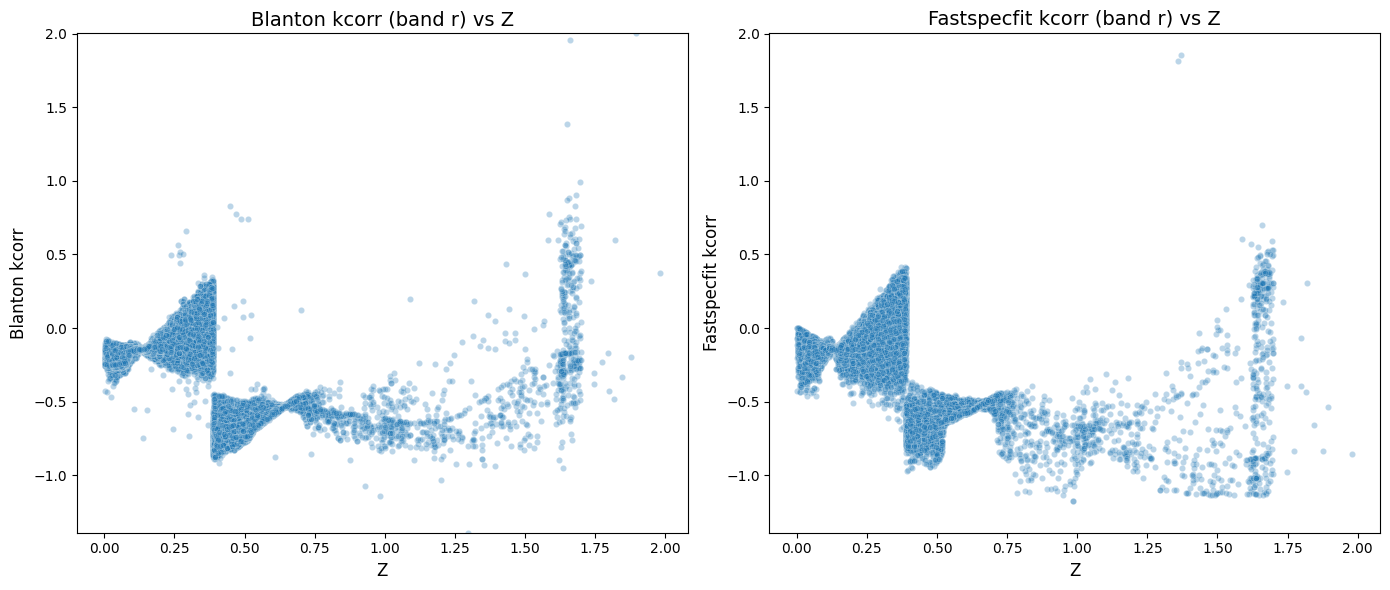

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for 'kcorr_sdss_01_r' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_R_BLANTON', ax=axes[0], s=20, alpha=0.3)
axes[0].set_title('Blanton kcorr (band r) vs Z', fontsize=14)
axes[0].set_xlabel('Z', fontsize=12)
axes[0].set_ylabel('Blanton kcorr', fontsize=12)

# Scatter plot for 'KCORR01_SDSS_R' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_R', ax=axes[1], s=20, alpha=0.3)
axes[1].set_title('Fastspecfit kcorr (band r) vs Z', fontsize=14)
axes[1].set_xlabel('Z', fontsize=12)
axes[1].set_ylabel('Fastspecfit kcorr', fontsize=12)

# Set the same y-range for both scatterplots
y_min = min(merged_df['KCORR01_SDSS_R_BLANTON'].min(), merged_df['KCORR01_SDSS_R'].min())
y_max = max(merged_df['KCORR01_SDSS_R_BLANTON'].max(), merged_df['KCORR01_SDSS_R'].max())
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


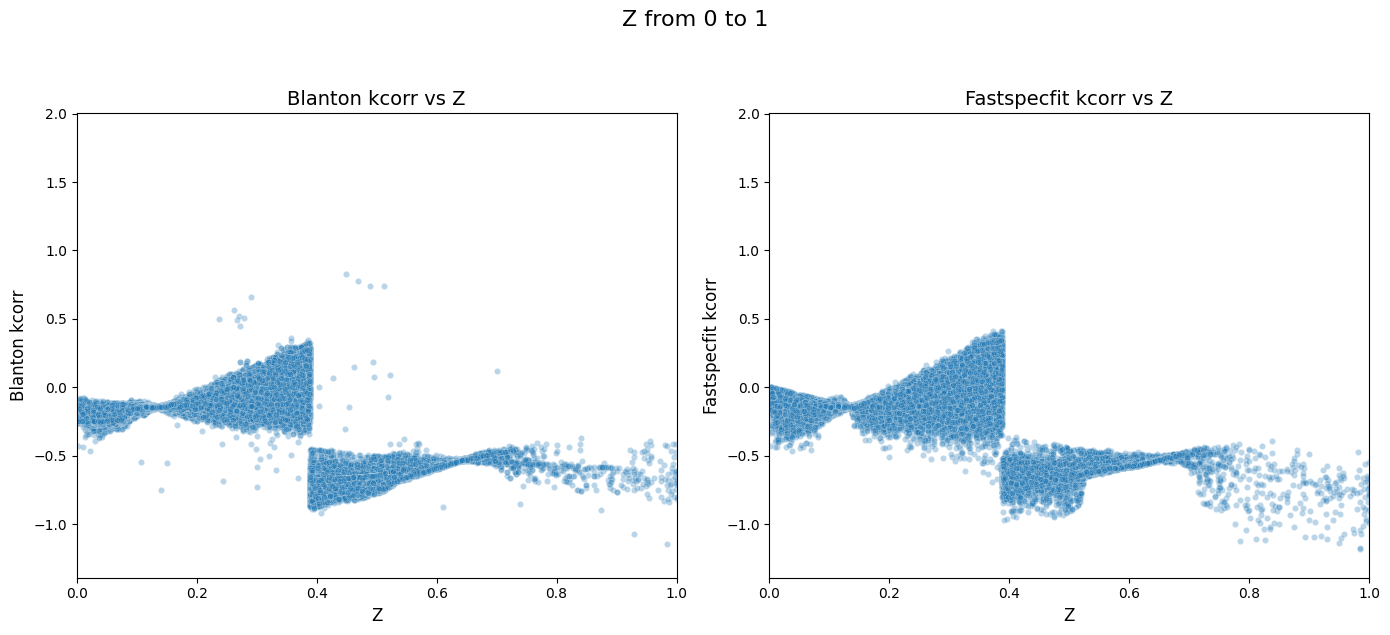

In [83]:
# Assuming merged_df is your DataFrame
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for 'kcorr_sdss_01_r' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_R_BLANTON', ax=axes[0], s=20, alpha=0.3)
axes[0].set_title('Blanton kcorr vs Z', fontsize=14)
axes[0].set_xlabel('Z', fontsize=12)
axes[0].set_ylabel('Blanton kcorr', fontsize=12)

# Scatter plot for 'KCORR01_SDSS_R' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_R', ax=axes[1], s=20, alpha=0.3)
axes[1].set_title('Fastspecfit kcorr vs Z', fontsize=14)
axes[1].set_xlabel('Z', fontsize=12)
axes[1].set_ylabel('Fastspecfit kcorr', fontsize=12)

# Set the same y-range for both scatterplots
y_min = min(merged_df['KCORR01_SDSS_R_BLANTON'].min(), merged_df['KCORR01_SDSS_R'].min())
y_max = max(merged_df['KCORR01_SDSS_R_BLANTON'].max(), merged_df['KCORR01_SDSS_R'].max())
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Restrict the x-axis (Z) to the range [0, 1]
axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

# Add a title on top for the entire figure
fig.suptitle('Z from 0 to 1', fontsize=16, y=1.05)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Error analysis

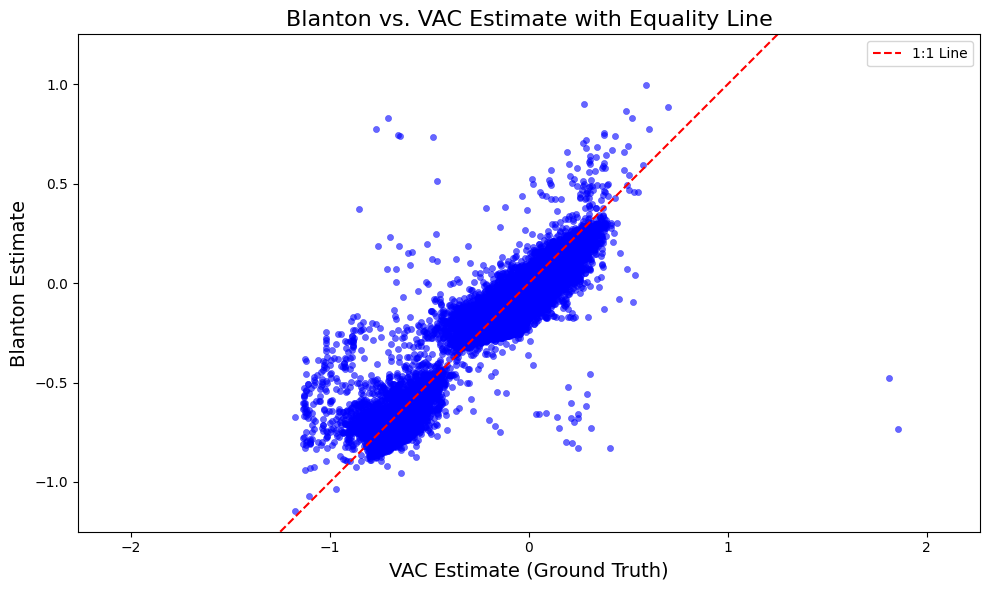

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='KCORR01_SDSS_R', 
    y='KCORR01_SDSS_R_BLANTON', 
    data=merged_df, 
    color="blue", 
    alpha=0.6, 
    edgecolor=None, 
    s=20  # Reduced marker size for smaller dots
)
plt.plot([-1.25, 2], [-1.25, 2], color='red', linestyle='--', label="1:1 Line")  # Identity line y = x
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.gca().set_aspect('equal', adjustable='datalim')  # Set equal aspect ratio
plt.xlabel("VAC Estimate (Ground Truth)", fontsize=14)
plt.ylabel("Blanton Estimate", fontsize=14)
plt.title("Blanton vs. VAC Estimate with Equality Line", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


There are two notorious clusters of points. One of the clusters seems to allign around the identity line, meaning that both distributions agree. The other cluster forms a vertical line and shows a mass o points where Blanton and Fastpecfit estimations disagree.

Let's assume VAC estimation to be perfect, and calculate the error of Blanton:

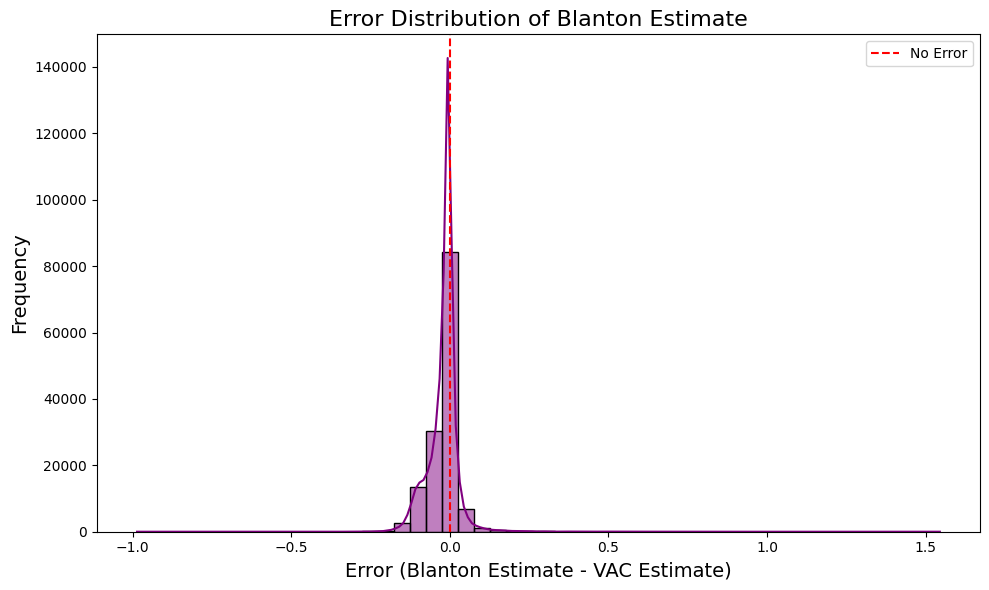

In [85]:
merged_df['error'] = merged_df['KCORR01_SDSS_R_BLANTON'] - merged_df['KCORR01_SDSS_R']

# Filter the data to restrict the domain
filtered_df = merged_df[(merged_df['error'] >= -1) & (merged_df['error'] <= 2)]

# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['error'], kde=True, color="purple", bins=50)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Error (Blanton Estimate - VAC Estimate)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Error Distribution of Blanton Estimate", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


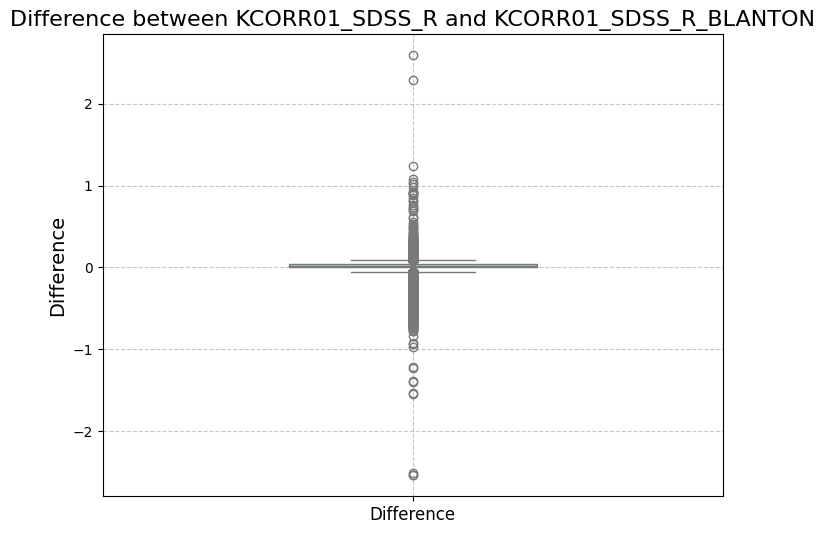

In [86]:
diff = merged_df['KCORR01_SDSS_R'] - merged_df['KCORR01_SDSS_R_BLANTON']

# Create a Seaborn boxplot with better aesthetics
plt.figure(figsize=(8, 6))
sns.boxplot(data=diff, color='lightblue', width=0.4)

# Customize the plot
plt.title('Difference between KCORR01_SDSS_R and KCORR01_SDSS_R_BLANTON', fontsize=16)
plt.ylabel('Difference', fontsize=14)
plt.xticks([0], ['Difference'], fontsize=12)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Aggregated stats

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = merged_df['KCORR01_SDSS_R']
y_pred = merged_df['KCORR01_SDSS_R_BLANTON']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("OVERALL STATS")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


OVERALL STATS
Mean Absolute Error (MAE): 0.0334
Mean Squared Error (MSE): 0.0034
Root Mean Squared Error (RMSE): 0.0579
R-squared (R²): 0.9505


# Beyond band r: Blanton vs FastSpecFit for bands g and z

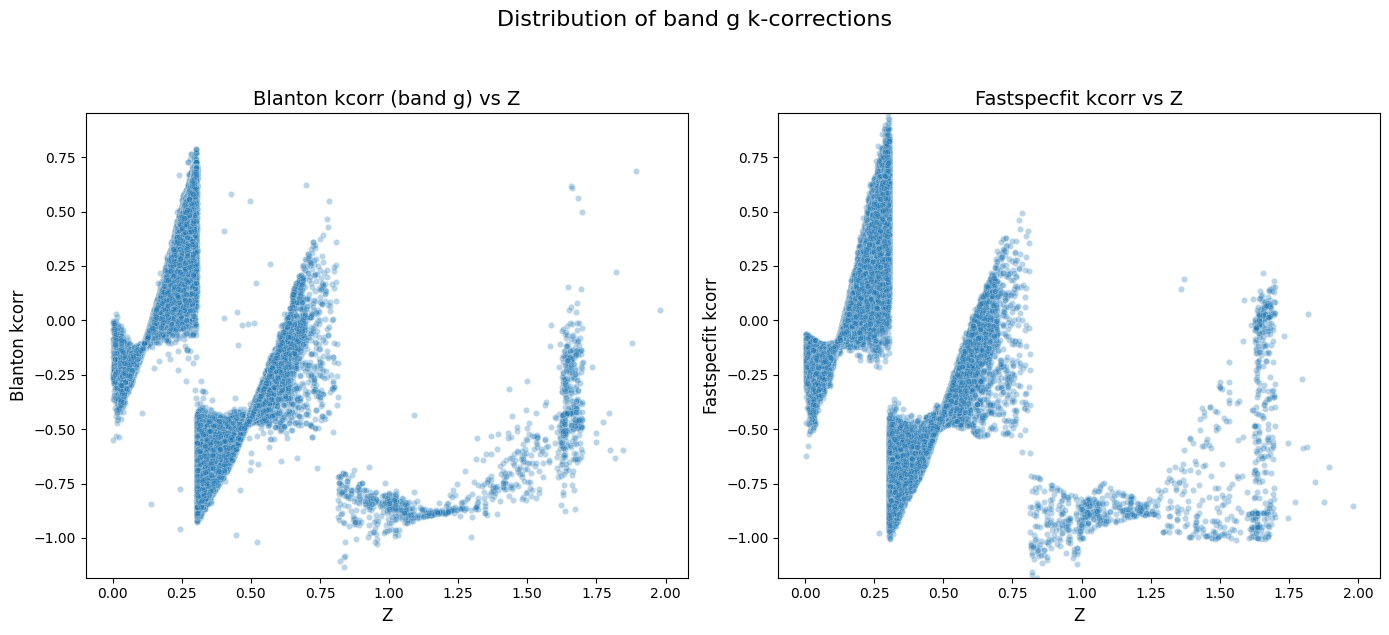

In [88]:
# Assuming merged_df is your DataFrame
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for 'kcorr_sdss_01_r' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_G_BLANTON', ax=axes[0], s=20, alpha=0.3)
axes[0].set_title('Blanton kcorr (band g) vs Z', fontsize=14)
axes[0].set_xlabel('Z', fontsize=12)
axes[0].set_ylabel('Blanton kcorr', fontsize=12)

# Scatter plot for 'KCORR01_SDSS_R' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_G', ax=axes[1], s=20, alpha=0.3)
axes[1].set_title('Fastspecfit kcorr vs Z', fontsize=14)
axes[1].set_xlabel('Z', fontsize=12)
axes[1].set_ylabel('Fastspecfit kcorr', fontsize=12)

# Set the same y-range for both scatterplots
y_min = min(merged_df['KCORR01_SDSS_G_BLANTON'].min(), merged_df['KCORR01_SDSS_G'].min())
y_max = max(merged_df['KCORR01_SDSS_G_BLANTON'].max(), merged_df['KCORR01_SDSS_G'].max())
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Restrict the x-axis (Z) to the range [0, 1]
#axes[0].set_xlim(0, 1)
#axes[1].set_xlim(0.8, 0.83)

# Add a title on top for the entire figure
fig.suptitle('Distribution of band g k-corrections', fontsize=16, y=1.05)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


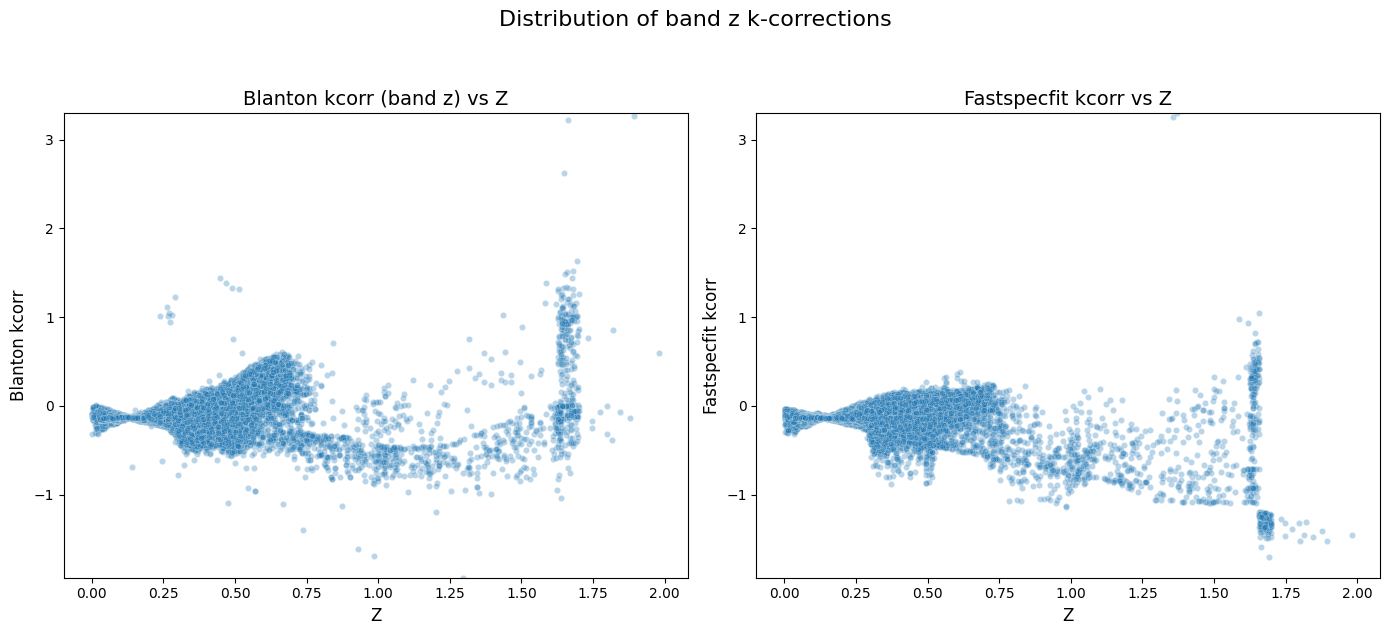

In [90]:
# Assuming merged_df is your DataFrame
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for 'kcorr_sdss_01_r' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_Z_BLANTON', ax=axes[0], s=20, alpha=0.3)
axes[0].set_title('Blanton kcorr (band z) vs Z', fontsize=14)
axes[0].set_xlabel('Z', fontsize=12)
axes[0].set_ylabel('Blanton kcorr', fontsize=12)

# Scatter plot for 'KCORR01_SDSS_R' vs 'Z' with smaller and transparent points
sns.scatterplot(data=merged_df, x='Z', y='KCORR01_SDSS_Z', ax=axes[1], s=20, alpha=0.3)
axes[1].set_title('Fastspecfit kcorr vs Z', fontsize=14)
axes[1].set_xlabel('Z', fontsize=12)
axes[1].set_ylabel('Fastspecfit kcorr', fontsize=12)

# Set the same y-range for both scatterplots
y_min = min(merged_df['KCORR01_SDSS_Z_BLANTON'].min(), merged_df['KCORR01_SDSS_Z'].min())
y_max = max(merged_df['KCORR01_SDSS_Z_BLANTON'].max(), merged_df['KCORR01_SDSS_Z'].max())
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Restrict the x-axis (Z) to the range [0, 1]
#axes[0].set_xlim(0, 1)
#axes[1].set_xlim(0, 1)

# Add a title on top for the entire figure
fig.suptitle('Distribution of band z k-corrections', fontsize=16, y=1.05)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


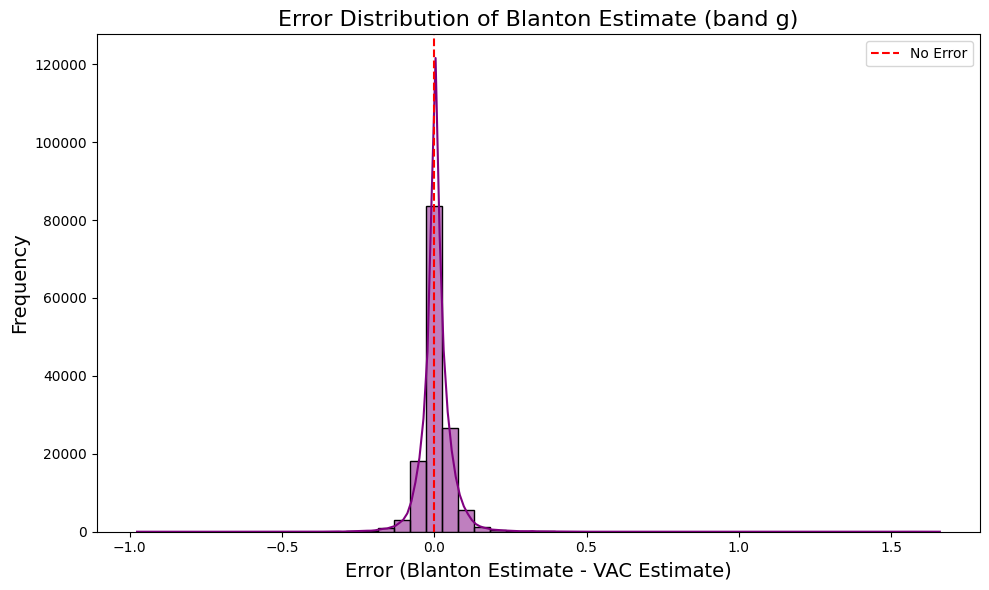

In [91]:
merged_df['error'] = merged_df['KCORR01_SDSS_G_BLANTON'] - merged_df['KCORR01_SDSS_G']

# Filter the data to restrict the domain
filtered_df = merged_df[(merged_df['error'] >= -1) & (merged_df['error'] <= 2)]

# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['error'], kde=True, color="purple", bins=50)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Error (Blanton Estimate - VAC Estimate)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Error Distribution of Blanton Estimate (band g)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

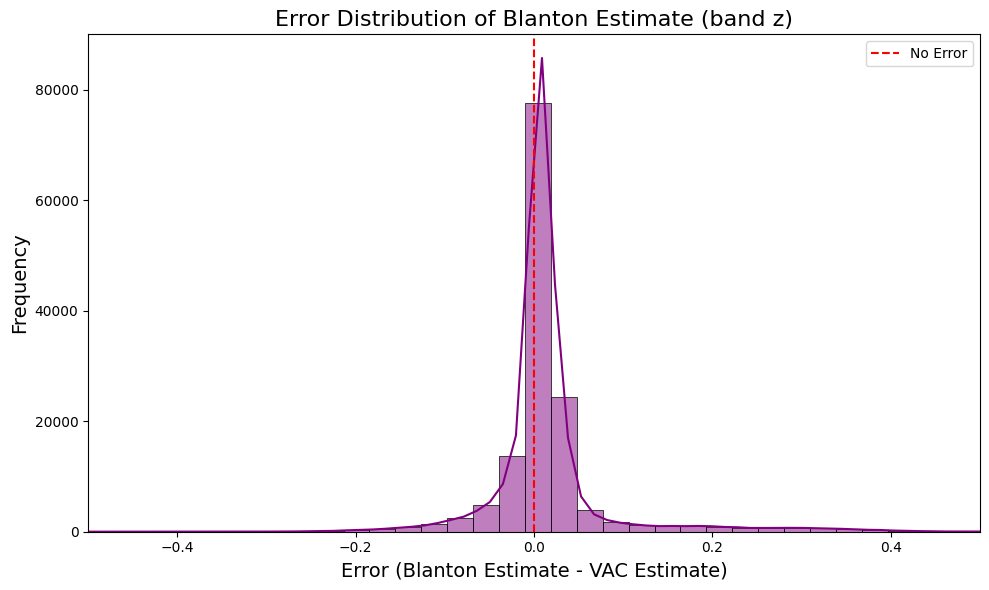

In [93]:
merged_df['error'] = merged_df['KCORR01_SDSS_Z_BLANTON'] - merged_df['KCORR01_SDSS_Z']

# Filter the data to restrict the domain
filtered_df = merged_df[(merged_df['error'] >= -1) & (merged_df['error'] <= 2)]

# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['error'], kde=True, color="purple", bins=100)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Error (Blanton Estimate - VAC Estimate)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((-0.5,0.5))
plt.title("Error Distribution of Blanton Estimate (band z)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

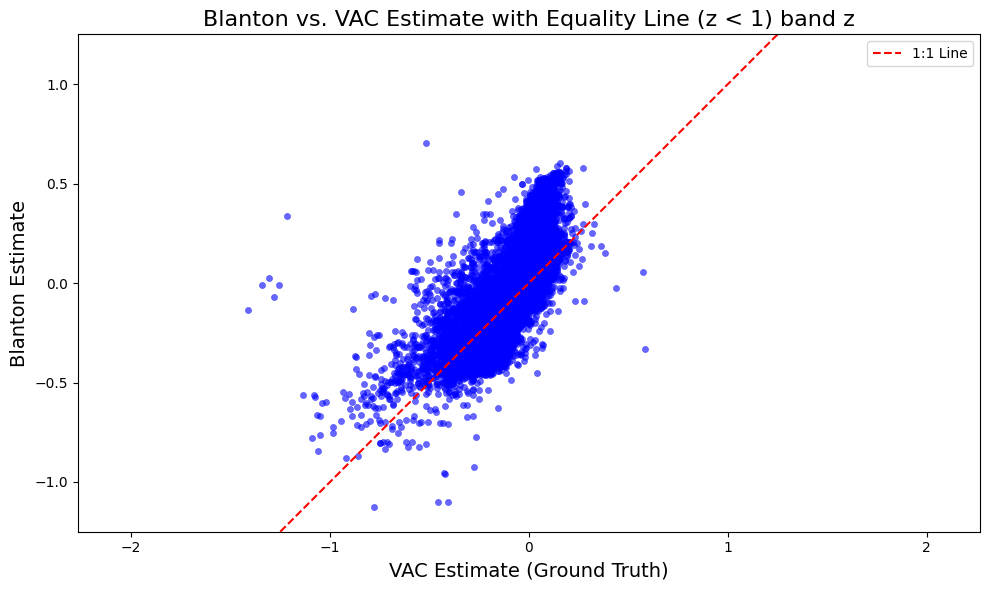

In [94]:
plt.figure(figsize=(10, 6))

filtered_df = merged_df[merged_df['z'] < 1]

# Scatter plot using the filtered dataframe
sns.scatterplot(
    x='KCORR01_SDSS_Z', 
    y='KCORR01_SDSS_Z_BLANTON', 
    data=filtered_df, 
    color="blue", 
    alpha=0.6, 
    edgecolor=None, 
    s=20  # Reduced marker size for smaller dots
)

# Add the equality line
plt.plot([-1.25, 2], [-1.25, 2], color='red', linestyle='--', label="1:1 Line")  # Identity line y = x

# Set limits and aspect ratio
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.gca().set_aspect('equal', adjustable='datalim')  # Set equal aspect ratio

# Add labels, title, and legend
plt.xlabel("VAC Estimate (Ground Truth)", fontsize=14)
plt.ylabel("Blanton Estimate", fontsize=14)
plt.title("Blanton vs. VAC Estimate with Equality Line (z < 1) band z", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
y_true = merged_df['KCORR01_SDSS_G']
y_pred = merged_df['KCORR01_SDSS_G_BLANTON']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("BAND G - OVERALL STATS")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


BAND G - OVERALL STATS
Mean Absolute Error (MAE): 0.0326
Mean Squared Error (MSE): 0.0036
Root Mean Squared Error (RMSE): 0.0599
R-squared (R²): 0.9805


In [98]:
y_true = merged_df['KCORR01_SDSS_Z']
y_pred = merged_df['KCORR01_SDSS_Z_BLANTON']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("BAND Z - OVERALL STATS")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

BAND Z - OVERALL STATS
Mean Absolute Error (MAE): 0.0370
Mean Squared Error (MSE): 0.0095
Root Mean Squared Error (RMSE): 0.0974
R-squared (R²): -0.1055


# Conclusion

| Band | Redshift Range    | MSE     | R²     |
|------|--------------------|---------|--------|
| r    | up to 0.37        | 0.0021  | 0.83   |
| r    | unrestricted       | 0.1566  | -1.44  |
| g    | up to 0.3         | 0.00245 | 0.95   |
| g    | unrestricted       | 0.7762  | -3.42  |
| z    | unrestricted       | 0.0052  | -0.05  |
 

BAND R: 
* For Z < 0.37 ; Blanton K correction and the VAC estimation tend to agree, although Blanton's estimation can often underestimates the estimation slightly. Average absolute error is ~0.03.
* For Z > 0.37 Blanton estimates diverge wildly from FastSpecFit estimations.

BAND G:
* Similar to band R, but the divergence takes place at Z ~ 0.3

BAND Z:
* This is a funny band. Does it even make sense to predict K corrections at band z for galaxies at this redshift? The VAC values seem unreliable, given they are mostly negative



# Adding noise to the redshift provided to Blanton's KCorrect
KCorrect relies heavily on the redshift parameter being provided. Let's add noise to the redshift and inspect the effect in Blanton's estimate reliability

In [29]:
blanton_kcorrs_path = "../data/blanton_kcorrs_005.pickle"

# These estimations have uniform noise in the redshift between [-0.05, 0.05]
with open(blanton_kcorrs_path,"rb") as f:
    kcorr_df_005 = pickle.load(f)

blanton_kcorrs_path = "../data/blanton_kcorrs_01.pickle"

# These estimations have uniform noise in the redshift between [-0.1, 0.1]
with open(blanton_kcorrs_path,"rb") as f:
    kcorr_df_01 = pickle.load(f)

# These estimations have uniform noise in the redshift between [-0.2, 0.2]
blanton_kcorrs_path = "../data/blanton_kcorrs_02.pickle"

with open(blanton_kcorrs_path,"rb") as f:
    kcorr_df_02 = pickle.load(f)

In [35]:
merged_df_005 = kcorr_df_005.merge(fastspec_df, on="targetid", how="inner")
merged_df_01 = kcorr_df_01.merge(fastspec_df, on="targetid", how="inner")
merged_df_02 = kcorr_df_02.merge(fastspec_df, on="targetid", how="inner")

In [31]:
def calculate_stats(band, df, z_limit):
    y_true = df['KCORR01_SDSS_'+band.title()][df['Z']<z_limit]
    y_pred = df['kcorr_sdss_01_'+band][df['Z']<z_limit]
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"BAND {band} - STATS FOR GALAXIES WHOSE Z < {z_limit}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
       

In [36]:
calculate_stats("g",merged_df,0.3)
calculate_stats("g",merged_df_005,0.3)
calculate_stats("g",merged_df_01,0.3)
calculate_stats("g",merged_df_02,0.3)

BAND g - STATS FOR GALAXIES WHOSE Z < 0.3
Mean Absolute Error (MAE): 0.0311
Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0501
R-squared (R²): 0.9588
BAND g - STATS FOR GALAXIES WHOSE Z < 0.3
Mean Absolute Error (MAE): 0.0696
Mean Squared Error (MSE): 0.0082
Root Mean Squared Error (RMSE): 0.0906
R-squared (R²): 0.8651
BAND g - STATS FOR GALAXIES WHOSE Z < 0.3
Mean Absolute Error (MAE): 0.1217
Mean Squared Error (MSE): 0.0238
Root Mean Squared Error (RMSE): 0.1544
R-squared (R²): 0.6088
BAND g - STATS FOR GALAXIES WHOSE Z < 0.3
Mean Absolute Error (MAE): 0.2148
Mean Squared Error (MSE): 0.0760
Root Mean Squared Error (RMSE): 0.2757
R-squared (R²): -0.2481


In [37]:
calculate_stats("r",merged_df,0.37)
calculate_stats("r",merged_df_005,0.3)
calculate_stats("r",merged_df_01,0.37)
calculate_stats("r",merged_df_02,0.37)

BAND r - STATS FOR GALAXIES WHOSE Z < 0.37
Mean Absolute Error (MAE): 0.0290
Mean Squared Error (MSE): 0.0021
Root Mean Squared Error (RMSE): 0.0462
R-squared (R²): 0.8317
BAND r - STATS FOR GALAXIES WHOSE Z < 0.3
Mean Absolute Error (MAE): 0.0310
Mean Squared Error (MSE): 0.0020
Root Mean Squared Error (RMSE): 0.0443
R-squared (R²): 0.7002
BAND r - STATS FOR GALAXIES WHOSE Z < 0.37
Mean Absolute Error (MAE): 0.0495
Mean Squared Error (MSE): 0.0043
Root Mean Squared Error (RMSE): 0.0657
R-squared (R²): 0.6603
BAND r - STATS FOR GALAXIES WHOSE Z < 0.37
Mean Absolute Error (MAE): 0.0746
Mean Squared Error (MSE): 0.0102
Root Mean Squared Error (RMSE): 0.1011
R-squared (R²): 0.1960


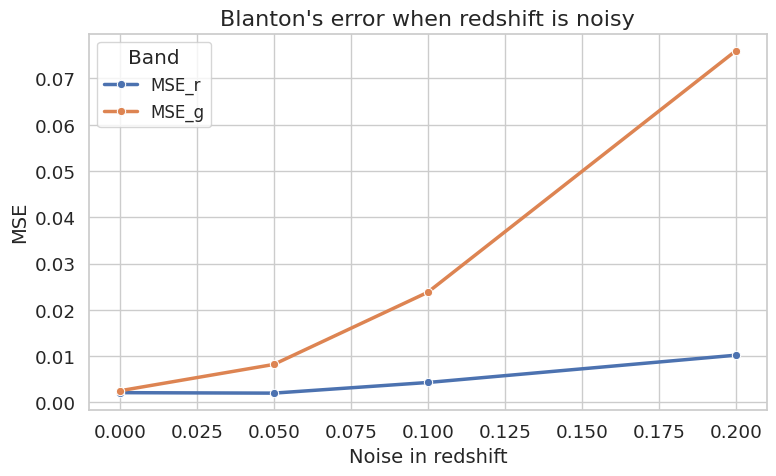

In [38]:
noise = [0, 0.05, 0.1, 0.2]
mse_r = [0.0021, 0.0020, 0.0043, 0.0102]
mse_g = [0.0025, 0.0082, 0.0238, 0.0760]

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Noise': noise,
    'MSE_r': mse_r,
    'MSE_g': mse_g
})

# Melt the DataFrame for seaborn compatibility
melted_data = data.melt(id_vars=['Noise'], value_vars=['MSE_r', 'MSE_g'], 
                        var_name='Band', value_name='MSE')

# Plot using seaborn
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))
sns.lineplot(data=melted_data, x='Noise', y='MSE', hue='Band', marker='o', linewidth=2.5)

# Add labels and title
plt.title("Blanton's error when redshift is noisy", fontsize=16)
plt.xlabel("Noise in redshift", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend(title="Band", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()